In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest

from src.strategies import VolumeSpike
from src import plotting
from src.crypto_data import BinanceDataManager

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/Users/ivankyulev/Projects/Notebooks/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
df = pd.read_csv("/Users/ivankyulev/Downloads/polymarket-price-data-26-07-2024-26-10-2024-1729899245705.csv")

In [10]:
df.index = pd.to_datetime(df["Timestamp (UTC)"], unit="s")

In [11]:
df

,Date (UTC),Timestamp (UTC),Donald Trump,Kamala Harris
Timestamp (UTC),,,,
2024-07-25 23:00:02,07-25-2024 23:00,1721948402,0.61,0.35
2024-07-26 00:00:02,07-26-2024 00:00,1721952002,0.61,0.35
2024-07-26 01:00:01,07-26-2024 01:00,1721955601,0.61,0.35
2024-07-26 02:00:01,07-26-2024 02:00,1721959201,0.61,0.35
2024-07-26 03:00:01,07-26-2024 03:00,1721962801,0.61,0.35
...,...,...,...,...
2024-10-25 20:00:03,10-25-2024 20:00,1729886403,0.65,0.35
2024-10-25 21:00:03,10-25-2024 21:00,1729890003,0.64,0.36
2024-10-25 22:00:02,10-25-2024 22:00,1729893602,0.64,0.36


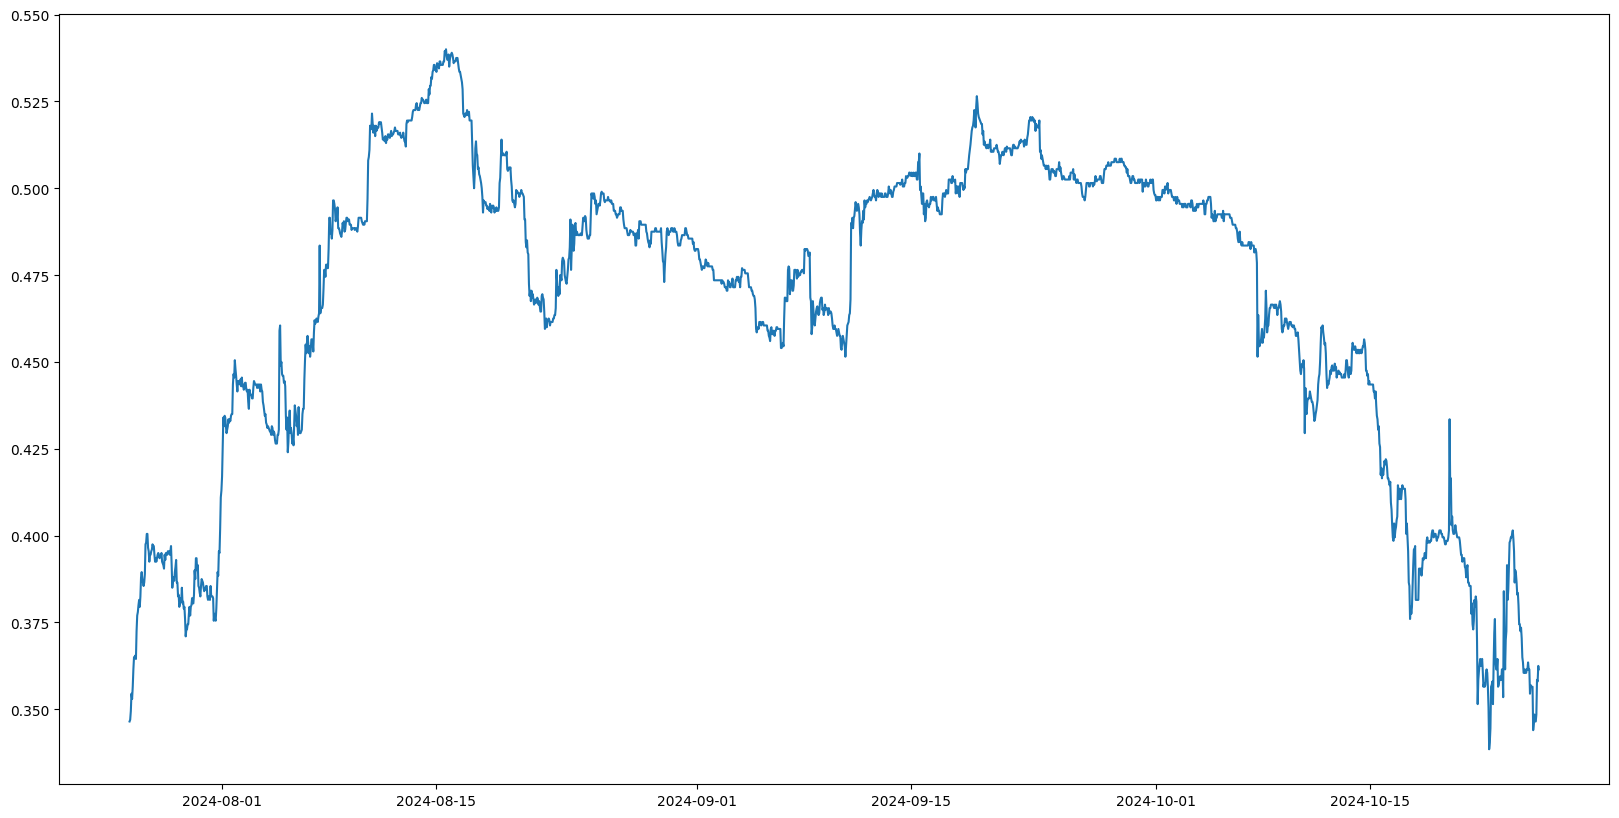

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(df.index, df["Kamala Harris"])